# Memory task machine learning
## Matt Oberhardt

### Initial setup

In [1]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt

In [2]:
# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)

Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Machine learning setup

In [3]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Run random forest after age-matching and sample balancing, with different feature sets

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

[]
dropped 299 rows to remove all nas from data
na rows have been dropped (if there were any)


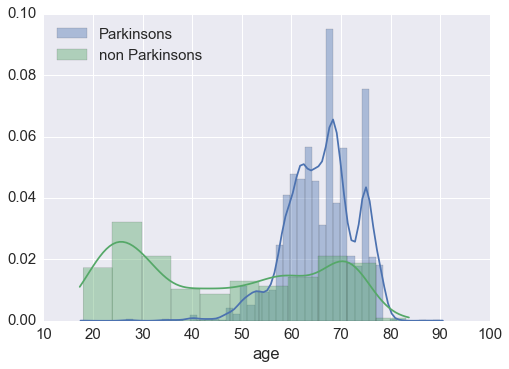

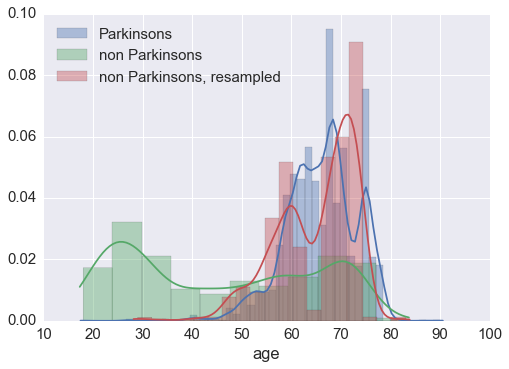

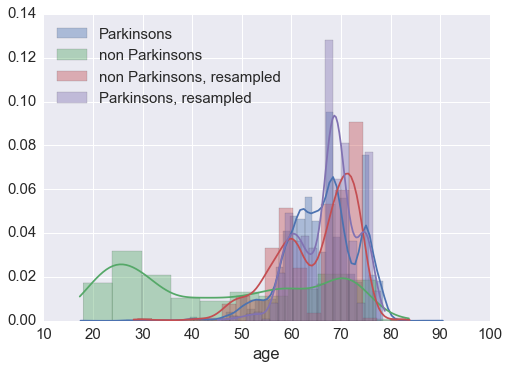

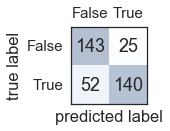

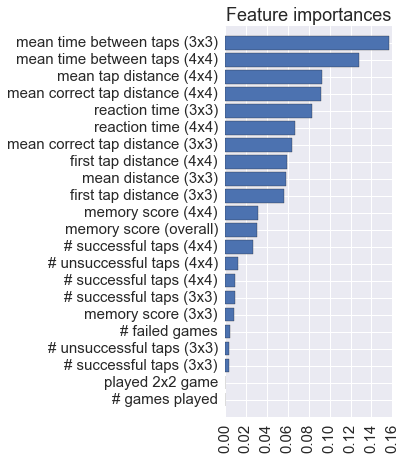

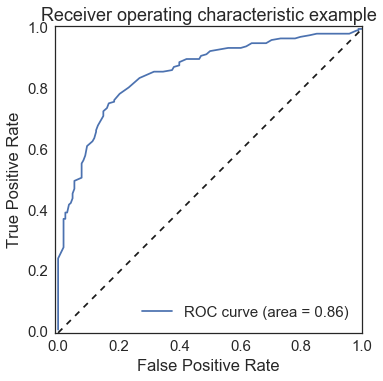



ranksum pval for dist. resampling = 0.0709490631283
ranksum pval for sample balanced = 0.000319033305734


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.848484848485
recall: 0.729166666667
F1: 0.78431372549
training accuracy: 1.0
test accuracy: 0.786111111111
random accuracy would be 0.5
##########################




In [4]:
# Run with only in-game features 
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + ['age']
MLexcludecols = ['age']
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[1,1,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs



Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

[]
dropped 299 rows to remove all nas from data
na rows have been dropped (if there were any)


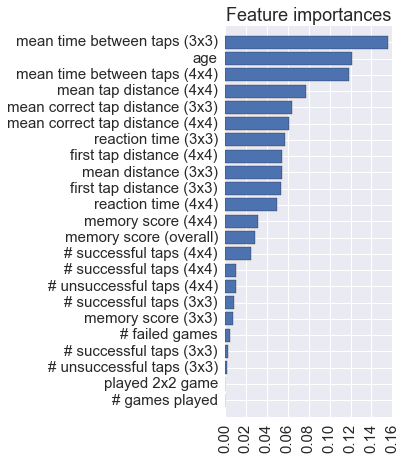

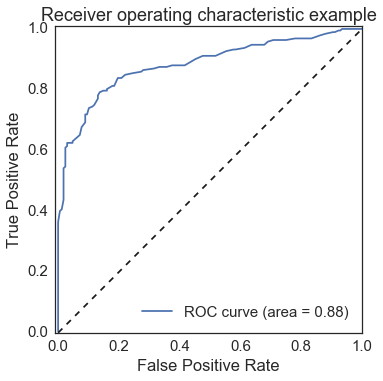



ranksum pval for dist. resampling = 0.126127788638
ranksum pval for sample balanced = 3.21255080072e-05


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.870588235294
recall: 0.770833333333
F1: 0.817679558011
training accuracy: 1.0
test accuracy: 0.816666666667
random accuracy would be 0.5
##########################




In [6]:
# Run with in-game features and age
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + ['age']
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    



Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)


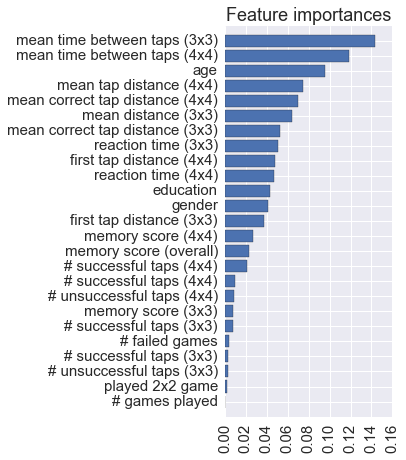

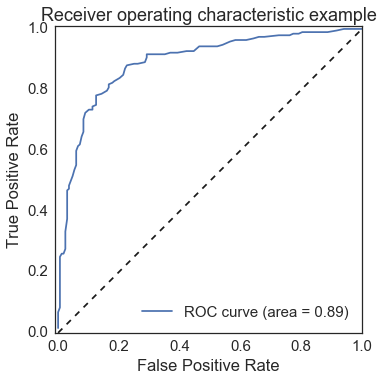



ranksum pval for dist. resampling = 0.0796973120004
ranksum pval for sample balanced = 0.00034954512655


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.862857142857
recall: 0.786458333333
F1: 0.822888283379
training accuracy: 1.0
test accuracy: 0.819444444444
random accuracy would be 0.5
##########################




In [8]:
# Run with in-game features and demographic features
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic']
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'phoneInfo', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)


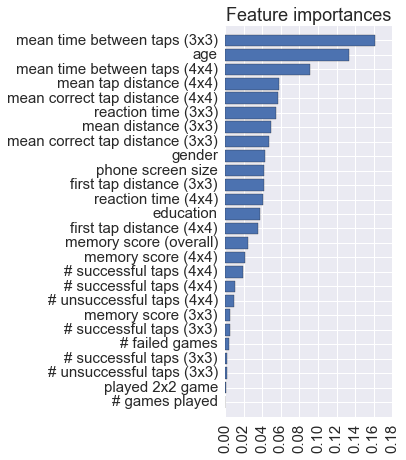

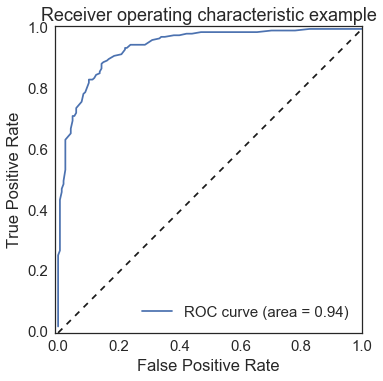



ranksum pval for dist. resampling = 0.446734171726
ranksum pval for sample balanced = 8.40236092061e-08


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.877005347594
recall: 0.854166666667
F1: 0.865435356201
training accuracy: 1.0
test accuracy: 0.858333333333
random accuracy would be 0.5
##########################




In [9]:
# Run with in-game features and demographic features and phone features
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
#fcats.rem
features.remove('smartphone')
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
# I think this one isn't fair with the smartphone feature added... so removed it


# TROUBLESHOOT. WHY IS IT WORKING SO WELL WITHOUT IN-GAME FEATURES????

['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


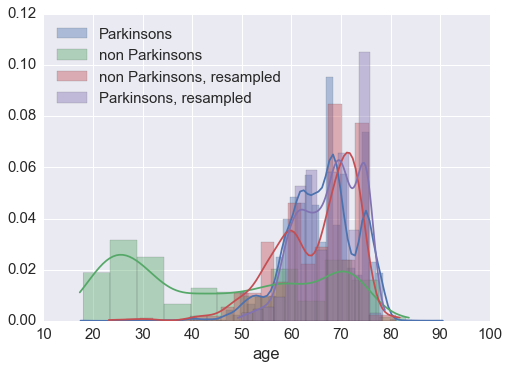

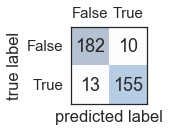

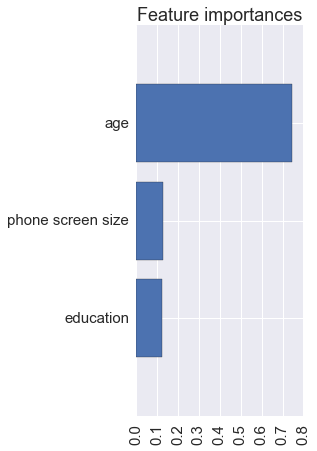

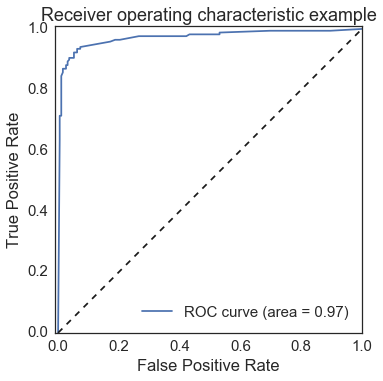



ranksum pval for dist. resampling = 0.189653539219
ranksum pval for sample balanced = 1.03795498897e-07


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.939393939394
recall: 0.922619047619
F1: 0.930930930931
training accuracy: 0.928571428571
test accuracy: 0.936111111111
random accuracy would be 0.5
##########################


[u'age' u'education' u'phoneInfo']


In [65]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names


na rows have been dropped (if there were any)


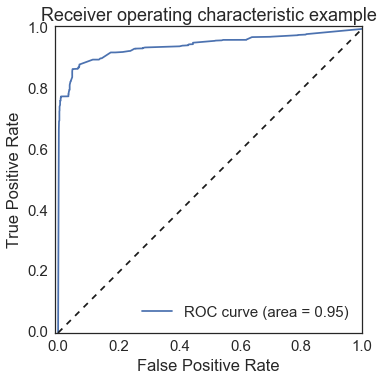

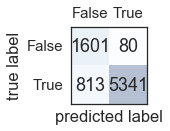

7835

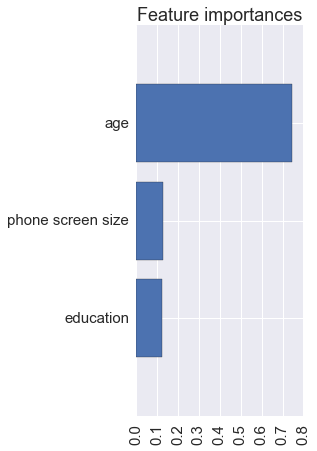

In [69]:
# try running on all data:

features_df, X_all, y_all, _X_names, _y_name, _X_train, _X_test, _y_train, _y_test = mt.prep_memory_features_for_machine_learning(fdf, features, labelcol, convert_features_to_nums=False, toStandardScale=False)


y_pred_proba_all = mod.predict_proba(X_all)[:,1]
y_pred_all = mod.predict(X_all)

mt.plot_roc_curve(y_all, y_pred_proba_all)
mt.render_confusion_matrix(y_all, y_pred_all)
mt.plot_feature_importances_randforest(mod, X_names)
len(X_all)
#print y_pred_proba_all



['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


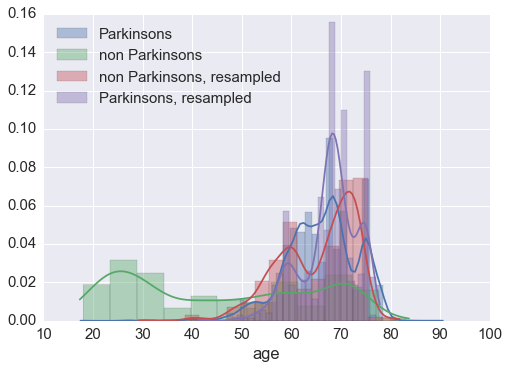

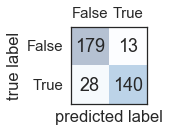

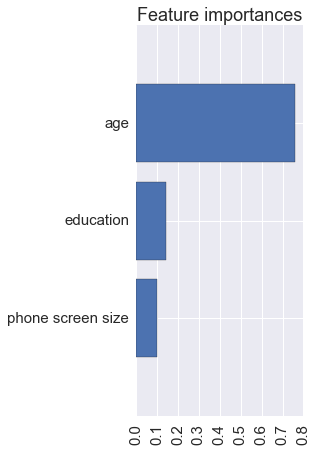

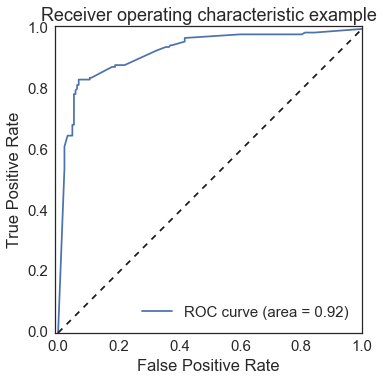



ranksum pval for dist. resampling = 0.133802433823
ranksum pval for sample balanced = 1.22077289194e-05


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.915032679739
recall: 0.833333333333
F1: 0.872274143302
training accuracy: 0.939285714286
test accuracy: 0.886111111111
random accuracy would be 0.5
##########################


[u'age' u'education' u'phoneInfo']
na rows have been dropped (if there were any)


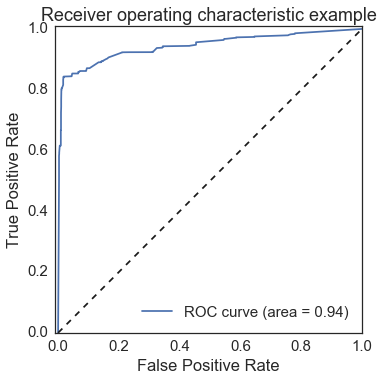

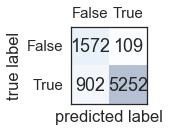

shape of X is:  (7835, 3)


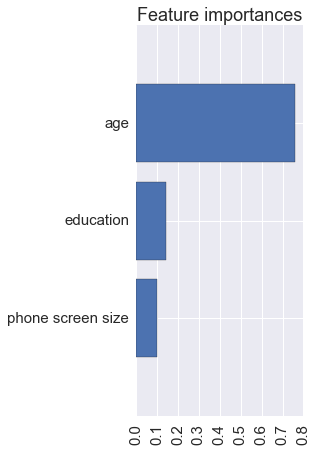

In [71]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names


# try running on all data:

features_df, X_all, y_all, _X_names, _y_name, _X_train, _X_test, _y_train, _y_test = mt.prep_memory_features_for_machine_learning(fdf, features, labelcol, convert_features_to_nums=False, toStandardScale=False)



y_pred_proba_all = mod.predict_proba(X_all)[:,1]
y_pred_all = mod.predict(X_all)

mt.plot_roc_curve(y_all, y_pred_proba_all)
mt.render_confusion_matrix(y_all, y_pred_all)
mt.plot_feature_importances_randforest(mod, X_names)
len(X_all)
#print y_pred_proba_all


print 'shape of X is: ', X_all.shape

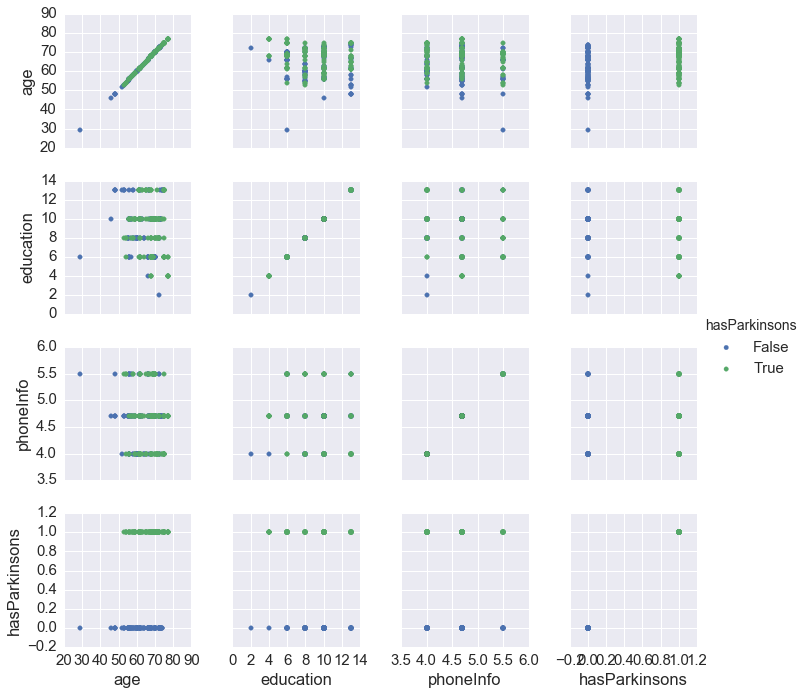

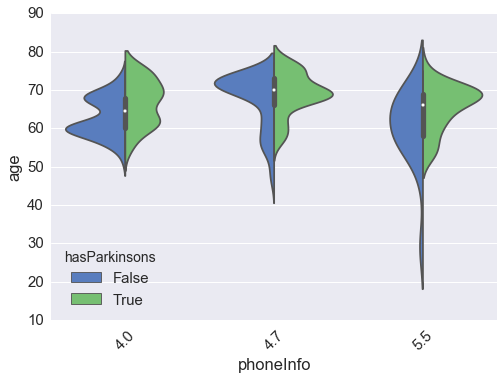

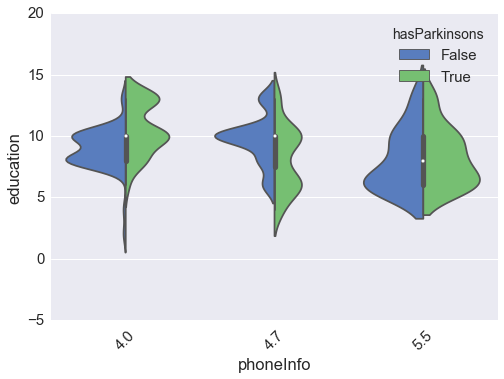

In [54]:
dftest = pd.DataFrame()
for i, name in enumerate(X_names):
    dftest[name] = X_test[:,i]

dftest['hasParkinsons'] = y_test
features_df = dftest

g = sns.PairGrid(features_df, hue="hasParkinsons")
g = g.map(plt.scatter)
g = g.add_legend()

yvar = 'hasParkinsons'
catvars = ['phoneInfo']
freqvars = ['age', 'education']
for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=features_df, palette="muted", split=True)    
        plt.xticks(rotation=45)

##g = sns.PairGrid(features_df)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

#mt.squaregridhistplot(dftest[y_test==True])
#mt.squaregridhistplot(dftest[y_test==False])

### Try running model with other outputs than Parkinsons

In [10]:
# Run with in-game features and demographic features and phone features
# predict 
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
MLexcludecols = ['hasParkinsons']
labelcol = 'medTimepoint'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=True, toPrint=True, MLexcludecols=MLexcludecols)    
! fix code !! 

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['smartphone', 'gender', 'phoneInfo', 'education']
dropped 303 rows to remove all nas from data


KeyError: 'hasParkinsons'

In [8]:
# visualize this new dataset (resampled):

##featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
##features_df = data[["game_score",'16_gamescore','hasParkinsons']]
#fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
#plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
##fplot = fplot.dropna()
#g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)


In [96]:
# run multiple iterations:

features = fcats['game'] + ['hasParkinsons'] + ['age']
#MLexcludecols = ['age']
MLexcludecols = []
labelcol = 'hasParkinsons'

numiters = 10

train_accs = []
test_accs = []
rand_accs = []

for n in range(numiters):
    print 'iteration %s' % n
    with mt.suppress_stdout():
        outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=False, toPrint=False, MLexcludecols=MLexcludecols)            

    mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc = outs
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    rand_accs.append(rand_acc)

        #return train_accs, test_accs, rand_accs

#with mt.suppress_stdout():
#    for n in range(numiters):

#for n in range(numiters):
#    print n
#    d = data.copy()

#    outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=False, toPrint=False, MLexcludecols=MLexcludecols)    


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [11]:
#print test_accs
#print np.mean(test_accs)
#ax = sns.boxplot(x="day", y="total_bill", data=tips)
#ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")

In [ ]:
#ax = sns.boxplot(x=test_accs, orient='v')
#ax = sns.swarmplot(data=test_accs, color=".25")

In [ ]:
# try predicting  

# Parkinsons patients: 322
# game records, Parkinsons 6164
# non-Parkinsons patients: 525
# game records, non-Parkinsons 1690


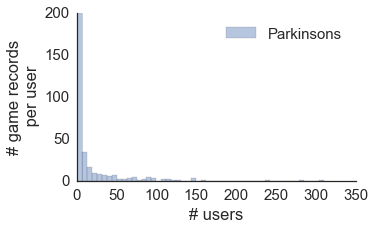

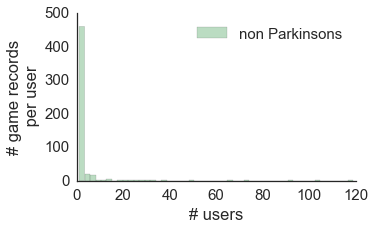

In [94]:
# visualize the data as a whole

#sns.
sns.set(style="white", font_scale=1.5)

Pgroups = data.groupby('hasParkinsons')
dp = Pgroups.get_group(True)
dnp = Pgroups.get_group(False)

# plot dists:
distP = dp['healthCode'].value_counts()
distNP = dnp['healthCode'].value_counts()

#array, bin_edges = np.histogram(data['healthCode'].value_counts(), bins=20)
#plt.figure()
#ax1 = sns.distplot(distP, kde=False, label='Parkinsons', bins=20)
#ax2 = sns.distplot(distNP, kde=False, label='non Parkinsons', bins=20)
#plt.xlabel('Users')
#plt.ylabel('# Game records per user')
#plt.legend(loc=4)

figsizes = (5,3)

plt.figure(figsize=figsizes)
ax1 = sns.distplot(distP, kde=False, label='Parkinsons', color='b')
plt.xlabel('# users')
plt.ylabel('# game records\n per user')
plt.legend(loc=1)
sns.despine()

plt.figure(figsize=figsizes)
ax2 = sns.distplot(distNP, kde=False, label='non Parkinsons', color='g')
plt.xlabel('# users')
plt.ylabel('# game records\n per user')
plt.legend(loc=1)
sns.despine()

print '# Parkinson''s patients:', len(distP)
print '# game records, Parkinson''s', distP.sum()

print '# non-Parkinson''s patients:', len(distNP)
print '# game records, non-Parkinson''s', distNP.sum()


In [10]:
# To Do:

# package the resampling code into a function

# add age back in as variable now, and rerun random forest
# try logistic regression, with l1 (lasso) (minimize # features)

# do pca of outputs, and see if we can be more predictive
# split data by person and check on drugs vs not on drugs (what is predictive)
# time series analysis of indiv. patients, looking at the yes and no data?
# symptom variance individual patients plot?
# run rand forest with all in-game features & sample balancing but not correction for age



In [32]:
data.shape

In [33]:
a = 2
a

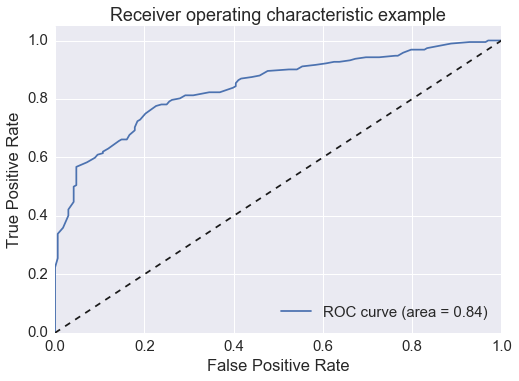